# CounterFactual detection Power

The counterfactual test asks the if the alternative pathway is different than the base pathway.  For this example we will assume there is some step change in the alternative pathway to 9.5 mg/l instead of 10 mg/l.  We will ask can we detect that the alternative pathway is less than the base pathway. 

## Paired t-test and Wilcoxon signed-rank test

Both the Paired t-test and the Wilcoxon signed-rank test are implemented.  These are both paired sample comparisons, with the paired t-test assuming parametric data, while the Wilconon works on non-parametric data.  Running detection power calculations with both of these tests is relatively easy.


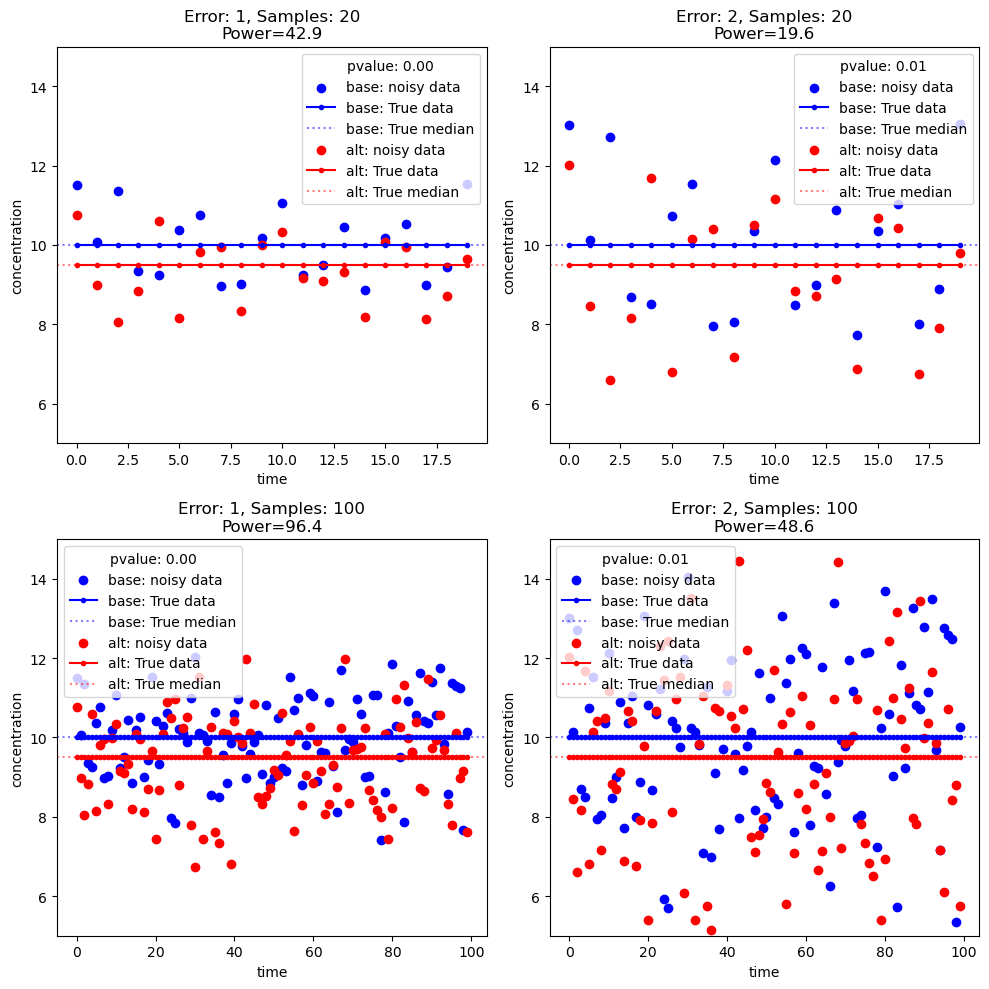

In [1]:
from gw_detect_power import DetectionPowerCounterFactual
import numpy as np
import matplotlib.pyplot as plt

errors = [1, 2]
samples = [20, 100]

dpc = DetectionPowerCounterFactual(significance_mode='wilcoxon-signed-rank-test', nsims=1000, p_value=0.05,
                                   alternative='alt<base',
                                   return_true_conc=True, return_noisy_conc_itters=1)

fig, axs = plt.subplots(nrows=len(samples), ncols=len(errors), figsize=(10, 10))

for i, error in enumerate(errors):
    for j, nsamp in enumerate(samples):
        # generate some random data
        ybase = np.full(nsamp, 10, )
        y_alt = np.full(nsamp, 9.5, )
        out = dpc.power_calc('temp', error_base=error, true_conc_base=ybase, true_conc_alt=y_alt, seed_base=5454,
                             seed_alt=5654)
        y0_alt = out['alt_noisy_conc'].iloc[:, 0]
        y0_base = out['base_noisy_conc'].iloc[:, 0]
        fig0, ax = dpc.plot_iteration(y0_base, y0_alt, true_conc_base=ybase, true_conc_alt=y_alt, ax=axs[j, i])
        ax.set_title(f'Error: {error}, Samples: {nsamp}\nPower={out["power"].loc["power"]:.1f}')
        ax.set_ylim(5, 15)

fig.tight_layout()
plt.show()

## Auto Detection power mode

The counterfactual detection power also has an Auto version, which makes it faster to run sources through the detection power calculations. Here we will examine whether two pathways can be differentiated under different error values.  The initial concentration is 10 mg/l, 

Base pathway
* increase to 12 mg/l over the next 10 years


Alternative pathway
* decrease to 9 mg/l over the next 10 years

Site specific parameters
* mrt = 2 year
* exponential fraction = 0.7
* a 2-year delay in sampling

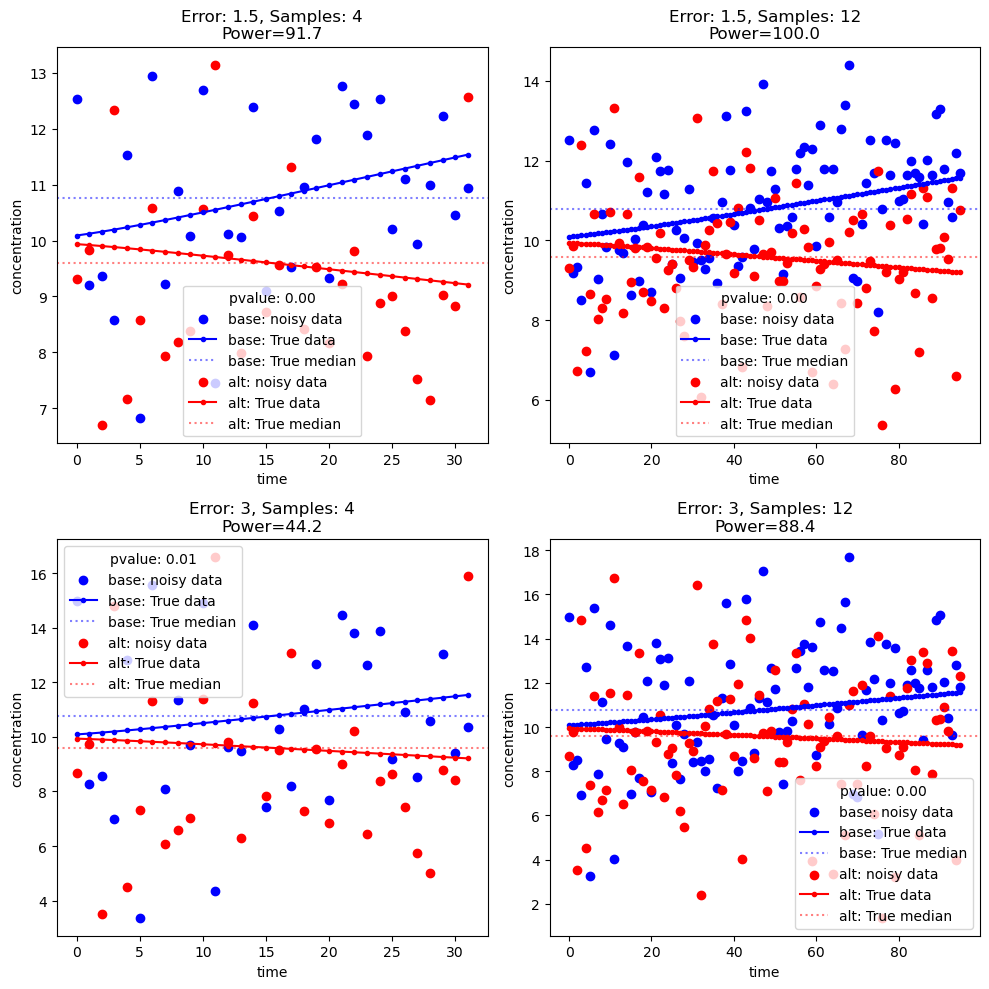

In [2]:
from gw_detect_power import AutoDetectionPowerCounterFactual

dp_auto = AutoDetectionPowerCounterFactual(significance_mode='wilcoxon-signed-rank-test',
                                           nsims=1000,
                                           p_value=0.05,
                                           min_samples=10,
                                           alternative='alt<base',
                                           wx_zero_method='wilcox', wx_correction=False, wx_method='auto',
                                           ncores=None,
                                           return_true_conc=True,
                                           return_noisy_conc_itters=1,
                                           only_significant_noisy=True,
                                           )

errors = [1.5, 3]
samples = [4, 12]

fig, axs = plt.subplots(nrows=len(samples), ncols=len(errors), figsize=(10, 10))

for j, noise in enumerate(errors):
    for i, samp in enumerate(samples):
        out = dp_auto.power_calc(
            idv='test',
            error_base=noise,
            mrt_model='binary_exponential_piston_flow',
            samp_years=10,
            samp_per_year=samp,
            implementation_time_alt=10,
            initial_conc=10,
            target_conc_alt=9,
            prev_slope=0,
            max_conc_lim=20,
            min_conc_lim=2,
            mrt=2,
            target_conc_base=12,
            implementation_time_base=10,
            error_alt=None,
            delay_years=2,
            mrt_p1=2,
            frac_p1=1,
            f_p1=0.7,
            f_p2=0.7,
            seed_base=1,
            seed_alt=2,
        )
        y0_alt = out['alt_noisy_conc'].iloc[:, 0]
        y0_base = out['base_noisy_conc'].iloc[:, 0]
        ybase = out['true_conc']['true_conc_base']
        y_alt = out['true_conc']['true_conc_alt']
        fig0, ax = dpc.plot_iteration(y0_base, y0_alt, true_conc_base=ybase, true_conc_alt=y_alt, ax=axs[j, i])
        ax.set_title(f'Error: {noise}, Samples: {samp}\nPower={out["power"].loc["power"]:.1f}')
        
fig.tight_layout()
plt.show()